# Assignment 2: Ensemble Methods and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**


## Name: 
## UNI: 


## Dataset Description: Bank Marketing Dataset

This dataset contains information about direct marketing campaigns (phone calls) of a banking institution. The goal is to predict whether the client will subscribe to a term deposit. The details of the features and target are listed below:

**Features**:
- `age`: Age of the client
- `job`: Type of job
- `marital`: Marital status
- `education`: Education level
- `default`: Has credit in default?
- `balance`: Average yearly balance
- `housing`: Has housing loan?
- `loan`: Has personal loan?
- `contact`: Contact communication type
- `day`: Last contact day of the month
- `month`: Last contact month of year
- `duration`: Last contact duration in seconds
- `campaign`: Number of contacts performed during this campaign
- `pdays`: Number of days since the client was last contacted from a previous campaign
- `previous`: Number of contacts performed before this campaign
- `poutcome`: Outcome of the previous marketing campaign
- `deposit`: Has the client subscribed to a term deposit? (target)

**Objective**: The target variable (`deposit`) is binary (yes/no), and the goal is to predict whether a client will subscribe to a term deposit based on the given features.



In [8]:
## Use this cell to import necessary packages

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


## Question 1: Decision Trees


**1.1: Load the Bank Marketing Dataset and inspect its structure.**
- Hint: Inspect columns and types.


In [9]:
## YOUR CODE HERE

bank_df = pd.read_csv('bank.csv')
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object


**1.2: Are there any missing values in the dataset? If yes, how do you plan to handle them?**


In [10]:
## YOUR CODE HERE

missing_values = bank_df.isnull().sum()
missing_values 

# There are no missing values.

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


**1.3: Plot side-by-side bars of class distribution for each categorical feature in the dataset with respect to the target variable (e.g., `job`, `marital`, `education`, etc.).**


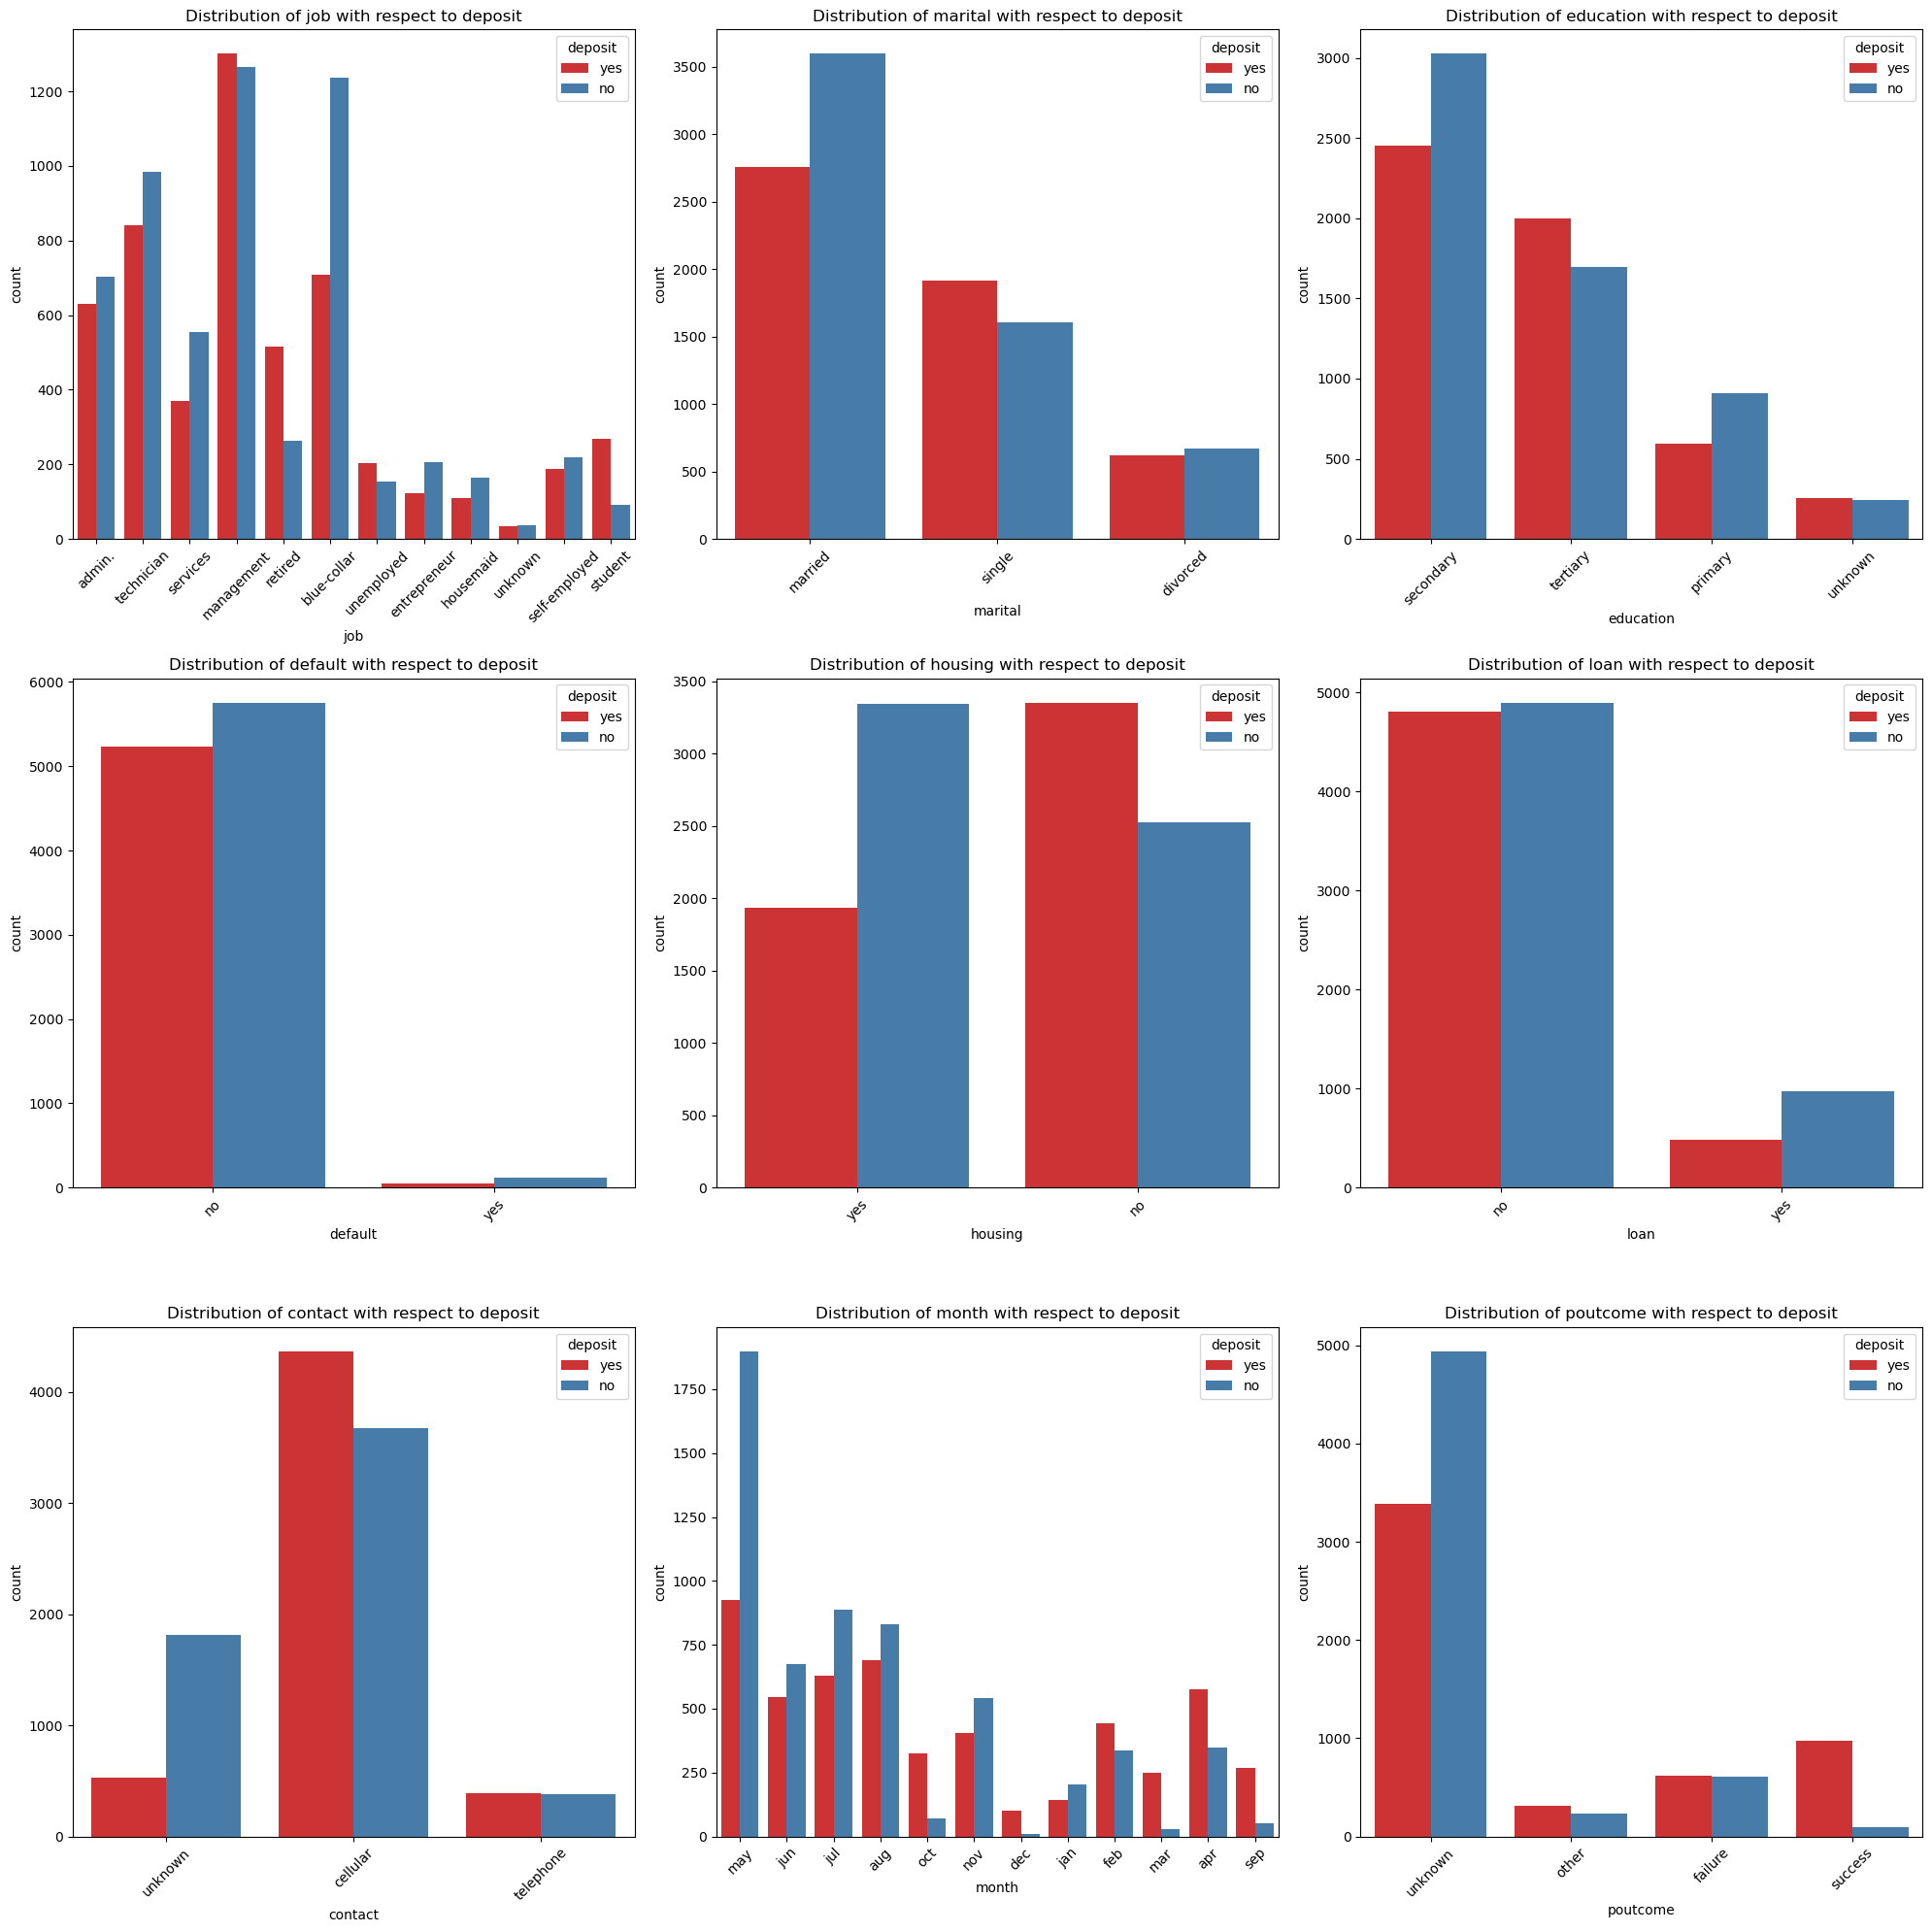

In [11]:
## YOUR CODE HERE

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

plt.figure(figsize=(20, 20))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i) 
    sns.countplot(data=bank_df, x=feature, hue='deposit', palette='Set1')
    plt.title(f'Distribution of {feature} with respect to deposit')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**1.4: Explain the distribution of the target variable and the dataset.**


In [12]:
## YOUR COMMENT HERE

# The distribution of the target variable 'deposit' is almost even, slightly leaned toward 'no'. About feature
# distributions, 'housing', 'month' and 'job' are relatively evenly distributed; for 'education', the higher the 
# degree the more distributed; and for 'maritial', 'married' accounts for a larger proportion. The vast majority 
# of clients have 'no credit defaults', 'no loan', 'unknown poutcome' and 'cellular contact'.

**1.5: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

**Hint: Based on the distribution of the data, try to use the best splitting strategy.**

In [13]:
## YOUR CODE HERE

X = bank_df.drop(columns=['deposit'])
y = bank_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**1.6: Would you drop any column? Justify your reasoning.**

**Preprocess the data (Handle the Categorical Variable). Would you consider a mix of encoding techniques? Justify.
Do we need to apply scaling? Briefly Justify**



In [14]:
## YOUR CODE HERE

X_train = X_train.drop(columns=['default'])
X_test = X_test.drop(columns=['default'])
categorical_features = list(set(categorical_features) - set(['default']))

# Label encoding for 'deposit'
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Ordinal encoding for 'month', 'job', 'education'
ordinal_features = ['month', 'job', 'education']
ordinal_encoder = OrdinalEncoder()
X_train[ordinal_features] = ordinal_encoder.fit_transform(X_train[ordinal_features])
X_test[ordinal_features] = ordinal_encoder.fit_transform(X_test[ordinal_features])

# One-hot encoding for other catagorical features
onehot_features = list(set(categorical_features) - set(ordinal_features))
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid dummy variable trap

features_train = onehot_encoder.fit_transform(X_train[onehot_features])
features_test = onehot_encoder.fit_transform(X_test[onehot_features])
features_columns = onehot_encoder.get_feature_names_out(onehot_features)

X_train = X_train.drop(columns=onehot_features)
X_test = X_test.drop(columns=onehot_features)
X_train[features_columns] = features_train
X_test[features_columns] = features_test

# Feature 'default' is dropped because according to the distribution chart it has a highly imbalanced distribution,
# with most clients having 'no'. Additionally, it has little effect in determining deposit subscription. Mixed 
# encoding strategy is used: ordinal encoding for 'month' and 'eduation' because they have a natural order, 'job'
# also uses oridinal encoding because it has many classes and might lead to high complexity if using one-hot; other
# categorical features use one-hot encoding. No need to do standardization, since decision trees are inherently 
# scale-invariant.

**1.7: Fit a Decision Tree on the development data until all leaves are pure. Which scoring metric will you prefer, and why? What is the performance of the tree on the development set and test set? Evaluate test and train accuarcy on F-1 score and accuracy.**

In [8]:
## YOUR CODE HERE

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# For this balanced dataset, accuracy scoring metric is sufficient. Because for imbalanced dataset, like 95% 'yes' and 5% 'no', 
# a model that simply predict 'yes' would get 95% accuracy. It won't tell us how the model is performing in terms of detecting
# the minority class.

Training F1 Score: 1.0
Test F1 Score: 0.7641418983700862
Training Accuracy: 1.0
Test Accuracy: 0.7796686072548141


**1.8: Visualize the trained tree until the suitable max_depth.**

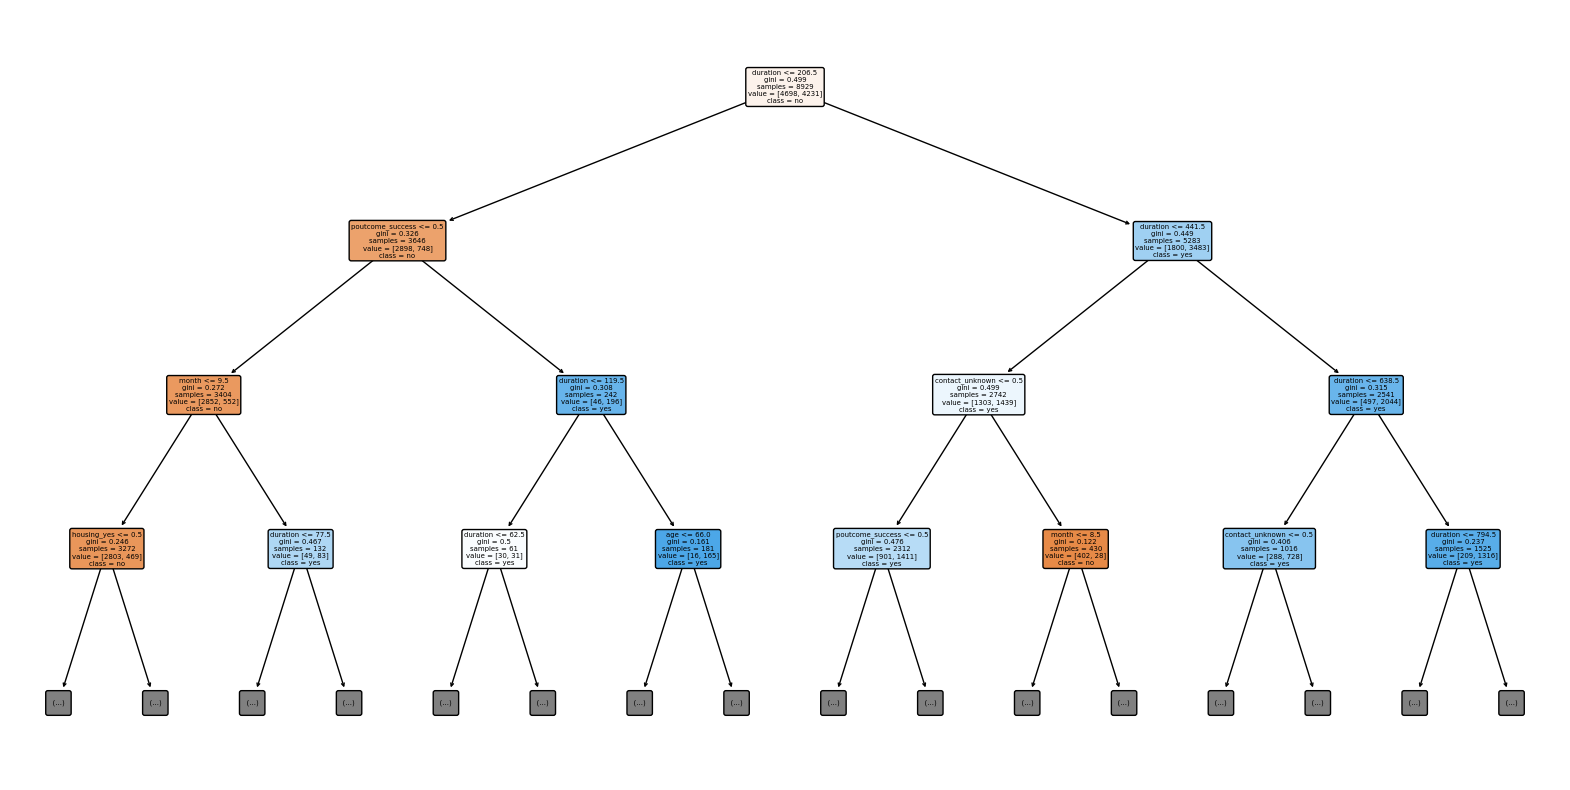

In [9]:
## YOUR CODE HERE

plt.figure(figsize=(20,10))
plot_tree(clf, max_depth=3, feature_names=X_train.columns, filled=True, class_names=['no', 'yes'], rounded=True)
plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance.**

**Print the optimal value of the tuned parameter.**

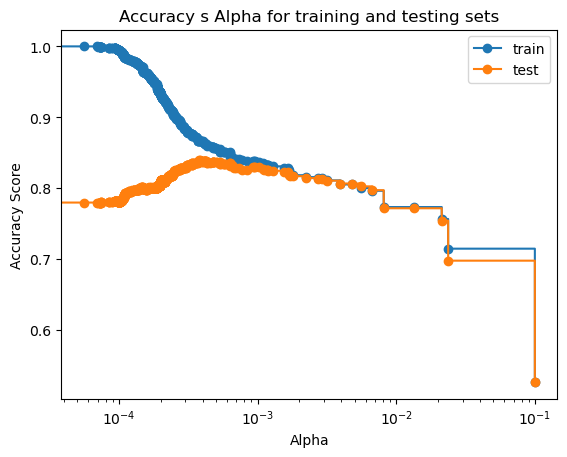

Best ccp_alpha: 0.00037898296025964603
Best Test Accuracy: 0.8396775638154949


In [10]:
## YOUR CODE HERE

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure()
plt.xlabel("Alpha")
plt.ylabel("Accuracy Score")
plt.title("Accuracy s Alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
plt.xscale('log')
plt.legend()
plt.show()

best_index = np.argmax(test_scores)
print(f"Best ccp_alpha: {ccp_alphas[best_index]}")
print(f"Best Test Accuracy: {test_scores[best_index]}")


**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

In [11]:
## YOUR CODE HERE

clf_pruned = clfs[best_index]
feature_importances = clf_pruned.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X_train.columns[sorted_indices[:3]]
print("Top 3 most important features are:", list(top_features))

# They have the highest feature importances calculated as the decrease in node impurity weighted by the probability 
# of reaching that node.

Top 3 most important features are: ['duration', 'poutcome_success', 'month']


## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Use accuracy and F1 score to evaluate. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.7)?**

In [48]:
## YOUR CODE HERE

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_test_pred = rf_clf.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_acc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.8481862964621585
Test F1 Score: 0.8435625288417167


**2.2: Do all trees in the trained random forest model have pure leaves? How would you verify that all trees have pure leaves? Print the score (mean accuracy) values of your choosen method**

In [51]:
## YOUR CODE HERE

all_pure = True
for tree_in_forest in rf_clf.estimators_:
    tree_ = tree_in_forest.tree_
    for node in range(tree_.node_count):
        is_leaf = (tree_.children_left[node] == -1) and (tree_.children_right[node] == -1)
        
        if is_leaf:
            impurity = tree_.impurity[node]
            if impurity > 0:
                all_pure = False

if all_pure:
    print("All trees have pure leaves.")
else:
    print("Not all tree have pure leaves.")
print(f"Test Score: {rf_clf.score(X_test, y_test)}")

All trees have pure leaves.
Test Score: 0.8481862964621585


**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


In [14]:
## YOUR SOLUTION HERE

# I would choose 'n_estimators', 'max_depth'. 'n_estimators' is the number of trees in the forest. More trees and deeper
# trees can help improve the performance but may cause high complexity and overfitting.

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

In [15]:
## YOUR SOLUTION HERE

param_grid = {
    'n_estimators': [70, 100, 130, 170, 200],
    'max_depth': [10, 15, 25, 30, None]
}

# I pick these values ​​near the default values ​​used by the previous model, to be overall smaller than previous value
# to prevent overfitting. Previous 'n_estimators' is 100 and the depth of trees of the previous model is around 30.

**2.5: Perform model selection using the chosen values for the hyperparameters. Use out-of-bag (OOB) error for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on train and test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [16]:
## YOUR CODE HERE

best_test_score = 0
best_hyperparams = {}

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        rf_clf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
        rf_clf.fit(X_train, y_train)
        score = rf_clf.score(X_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth}

train_score = rf_clf.score(X_train, y_train)

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Test Accuracy: {best_test_score}")
print(f"Train Accuracy: {train_score}")


Best Hyperparameters: {'n_estimators': 70, 'max_depth': 30}
Best Test Accuracy: 0.8504254366323332
Train Accuracy: 1.0


 **2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.10? If they differ, which feature set makes more sense?**

In [17]:
## YOUR CODE HERE

best_rf_clf = RandomForestClassifier(random_state=42, **best_hyperparams)
best_rf_clf.fit(X_train, y_train)
feature_importances = best_rf_clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X_train.columns[sorted_indices[:3]]
print("Top 3 most important features are:", list(top_features))

# Important features here are 'duration', 'balance' and 'age';  previous ones are 'duration', 'poutcome_success' and 'month'.
# Personally, I think the current feature set with 'balance' and 'age' makes more sense intuitively. For the previous feature set, 
# 'poutcome_success' make sense but I don't see connections between 'month' and the label.

Top 3 most important features are: ['duration', 'balance', 'age']


## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. For each hyperparmeter, give it 3 potential values. Report on the time taken to do model selection for the model. Also, report the performance of the test dataset from the optimal models.**

In [18]:
## YOUR CODE HERE

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_regularization': [0.0, 1.0, 10.0],
    'min_samples_leaf': [20, 50, 100]
}

hgb_clf = HistGradientBoostingClassifier(random_state=42)

start_time = time.time()
grid_search_hgb_clf = GridSearchCV(estimator=hgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_hgb_clf.fit(X_train, y_train)
end_time = time.time()

best_hyperparams = grid_search_hgb_clf.best_params_
best_hgb_clf = grid_search_hgb_clf.best_estimator_

best_score = best_hgb_clf.score(X_test, y_test)

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Test Accuracy: {best_score}")
print(f"Time taken for model selection: {end_time - start_time:.3f} seconds")

Best Hyperparameters: {'l2_regularization': 10.0, 'learning_rate': 0.1, 'min_samples_leaf': 50}
Best Test Accuracy: 0.8575906851768921
Time taken for model selection: 85.621 seconds


**3.2: Repeat 3.1 for XGBoost.**

**Note**: For XGBoost, you **DO NOT HAVE TO** choose the same hyperparameters as HistGradientBoostingClassifier.

In [19]:
## YOUR CODE HERE

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [2, 4, 6]
}

xgb_clf = XGBClassifier(random_state=42)

start_time = time.time()
grid_search_xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_xgb_clf.fit(X_train, y_train)
end_time = time.time()

best_hyperparams = grid_search_xgb_clf.best_params_
best_xgb_clf = grid_search_xgb_clf.best_estimator_

best_score = best_xgb_clf.score(X_test, y_test)

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Test Accuracy: {best_score}")
print(f"Time taken for model selection: {end_time - start_time:.3f} seconds")

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6}
Best Test Accuracy: 0.8571428571428571
Time taken for model selection: 28.486 seconds


**3.3: Compare the results on the test dataset of XGBoost and HistGradientBoostingClassifier. Which model do you prefer and why?**

In [20]:
## YOUR COMMENT HERE

# XGBoost and HistGradientBoostingClassifier yield similarly excellent accuracy on the test dataset. XGBoost is more efficient
# taking only one-third of the time HistGradientBoostingClassifier needs so I prefer XGBoost a little more.

**3.4: Can you list the top 3 important features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree?**

In [21]:
## YOUR CODE HERE

feature_importances = best_xgb_clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X_train.columns[sorted_indices[:3]]
print("Top 3 most important features are:", list(top_features))

# 'Duration' is the same on all three models. 'poutcome_success' is the same as the Decision Tree model. I think the three
# features listed here 'duration', 'poutcome_success' and 'contact_unknown' all make sense.

Top 3 most important features are: ['poutcome_success', 'contact_unknown', 'duration']


**3.5: Can you choose the top 5 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [22]:
## YOUR CODE HERE

X_train_reduced = X_train.iloc[:, sorted_indices[:5]]
X_test_reduced = X_test.iloc[:, sorted_indices[:5]]

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [2, 4, 6]
}

xgb_clf = XGBClassifier(random_state=42)

start_time = time.time()
grid_search_xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_xgb_clf.fit(X_train_reduced, y_train)
end_time = time.time()

best_hyperparams = grid_search_xgb_clf.best_params_
best_xgb_clf = grid_search_xgb_clf.best_estimator_

best_score = best_xgb_clf.score(X_test_reduced, y_test)

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Test Accuracy: {best_score}")
print(f"Time taken for model selection: {end_time - start_time:.3f} seconds")

# The performance accuracy here drops for a little bit. I suppose the reason why is that the selection of top-5
# features filters out some useful feature despite reducing noise. But we can see that even with only 5 features
# the accuracy still remains at a good level. That implies these top-5 features are the ones that really matter. 
# It also reduces model complexity and save running time and memory.

Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4}
Best Test Accuracy: 0.8423645320197044
Time taken for model selection: 17.668 seconds


## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [23]:
## YOUR CODE HERE

**4.2: Calibrate the trained XGBoost model using isotonic regression. Print the brier score after calibration and plot predicted v.s. actual on test datasets from the calibration method.**

In [24]:
## YOUR CODE HERE

**4.3: Compare the brier scores from 4.1 and 4.2. Do the calibration methods help in having better predicted probabilities?**

Your Comments Here